In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Original dataset
raw = pd.read_csv("../OnlineNewsPopularity.csv")

# Results of my own scraping
update_data = pd.read_csv("Updates.csv").set_index('url')

print(len(update_data))

39644


# Updates Dataframe
Since this was data scrapped from the articles, its bound to be a bit messy

In [23]:
update = update_data.copy()

# Sperate the time stamp into weekday and date
update['weekday'] = update['date'].str.split(",", n = 1, expand = True)[0]
update['date'] = pd.to_datetime(update['date'].str.split(",", n = 1, expand = True)[1])

# Edit text of titles and keywords
def remove_text(column,text_list):
    update[column] = update[column].str.lower()
    for string in text_list:
        update[column] = update[column].str.replace(string,'')
        
remove = [r"\<.*?\>",'amp;','[',']']
remove_text('keywords',remove)
remove_text('title',remove)

update.head()

,channel,date,title,keywords,weekday
url,,,,,
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,Entertainment,2013-01-07,this astronaut is rooting for notre dame tonight,"space, college football, entertainment, sports",Mon
http://mashable.com/2013/01/07/earth-size-planets-milky-way/,World,2013-01-07,there are 17 billion earth-size alien planets ...,"alien planets, earth, space, world",Mon
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,Business,2013-01-07,apple's app store passes 40 billion downloads,"apple, apps, apps and software, business, mobile",Mon
http://mashable.com/2013/01/07/downton-abbey-tumblrs/,Culture,2013-01-07,8 'downton abbey' tumblrs suitable for aristoc...,"downton abbey, gallery, memes, tumblr, televis...",Mon
http://mashable.com/2013/01/07/att-u-verse-apps/,Tech,2013-01-07,new u-verse apps simplify sharing photos and v...,"apps, apps and software, at&t, ces, tech",Mon


# Join Dataframes

In [24]:
data = raw.join(update, on='url',how='inner').set_index('url').dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39469 entries, http://mashable.com/2013/01/07/amazon-instant-video-browser/ to http://mashable.com/2014/12/27/youtube-channels-2015/
Data columns (total 65 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   timedelta                       39469 non-null  float64       
 1   n_tokens_title                  39469 non-null  float64       
 2   n_tokens_content                39469 non-null  float64       
 3   n_unique_tokens                 39469 non-null  float64       
 4   n_non_stop_words                39469 non-null  float64       
 5   n_non_stop_unique_tokens        39469 non-null  float64       
 6   num_hrefs                       39469 non-null  float64       
 7   num_self_hrefs                  39469 non-null  float64       
 8   num_imgs                        39469 non-null  float64       
 9   num_videos                      3946

# Days of the Week
First of, since we have a new days of the week column, I'm going to drop the origionals

In [25]:
data = data.drop(columns=['weekday_is_monday','weekday_is_tuesday','weekday_is_wednesday',
                          'weekday_is_thursday','weekday_is_friday','weekday_is_saturday',
                          'weekday_is_sunday','is_weekend'])

In [26]:
def break_down(column,sort='total articles',show=True):
    counts = data[[column,'shares']].groupby(by=column).count().rename(columns={'shares':'total articles'})
    sums = data[[column,'shares']].groupby(by=column).sum().rename(columns={'shares':'sum shares'})
    group = counts.join(sums,on=column)
    
    # add the shares per article ratio
    group["shares per article ratio"] = group["sum shares"]/group["total articles"]

    # add percentages to make it easier to see
    group['percent of all shares'] = group['sum shares']/group['sum shares'].sum()*100
    group['percent of articles'] = group['total articles']/group['total articles'].sum()*100

    # sort
    group = group.sort_values('total articles',ascending=False)
    
    if show==True:
        group
    
    return group

break_down('weekday')

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
weekday,,,,,
Wed,7502,25025256,3335.811250,18.690538,19.007322
Thu,7298,22993786,3150.696903,17.173300,18.490461
Tue,7187,24285807,3379.129957,18.138268,18.209227
Mon,6324,21947668,3470.535737,16.391989,16.022701
Fri,5998,19789487,3299.347616,14.780115,15.196737
Sat,2726,10806802,3964.344094,8.071244,6.906686
Sun,2434,9043838,3715.627773,6.754544,6.166865


Seems like less articles are published on Saturday and Sunday so I combined both these entries as `weekend`

In [27]:
data['weekday'] = data['weekday'].replace(['Sat','Sun'],'Weekend')
break_down('weekday')         

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
weekday,,,,,
Wed,7502,25025256,3335.811250,18.690538,19.007322
Thu,7298,22993786,3150.696903,17.173300,18.490461
Tue,7187,24285807,3379.129957,18.138268,18.209227
Mon,6324,21947668,3470.535737,16.391989,16.022701
Fri,5998,19789487,3299.347616,14.780115,15.196737
Weekend,5160,19850640,3847.023256,14.825788,13.073551


# Data Channels
Do the same with data channel

In [29]:
data = data.drop(columns=['data_channel_is_lifestyle',' data_channel_is_entertainment','data_channel_is_bus',
                          'data_channel_is_socmed','data_channel_is_tech','data_channel_is_world'])

In [30]:
break_down('channel')

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
channel,,,,,
Entertainment,10776,35497984,3294.170750,26.512274,27.302440
World,7616,24084453,3162.349396,17.987884,19.296156
Tech,7260,25208532,3472.249587,18.827421,18.394183
Business,6180,21250001,3438.511489,15.870925,15.657858
Culture,5250,19215172,3660.032762,14.351178,13.301578
Unlabeled,1182,3601668,3047.096447,2.689967,2.994755
U.S.,883,3673081,4159.774632,2.743303,2.237199
Social Good,322,1361753,4229.046584,1.017048,0.815830


The most articles are from the `Entertainment` category, followed by `World` and `Tech`. Understandably the highest sum shares come from the same categories.

Since `Social Good`, `US`, and the unlabeled data channels are so small, I just grouped them up into one category labeled `Other`

In [31]:
data['channel'] = data['channel'].replace(['Social Good','U.S.','Unlabeled'],'Other')
break_down('channel') 

,total articles,sum shares,shares per article ratio,percent of all shares,percent of articles
channel,,,,,
Entertainment,10776,35497984,3294.170750,26.512274,27.302440
World,7616,24084453,3162.349396,17.987884,19.296156
Tech,7260,25208532,3472.249587,18.827421,18.394183
Business,6180,21250001,3438.511489,15.870925,15.657858
Culture,5250,19215172,3660.032762,14.351178,13.301578
Other,2387,8636502,3618.140762,6.450319,6.047784


# Distribution of Shares
Now that the weekdays and channels have been updated, lets look at the shares as a whole

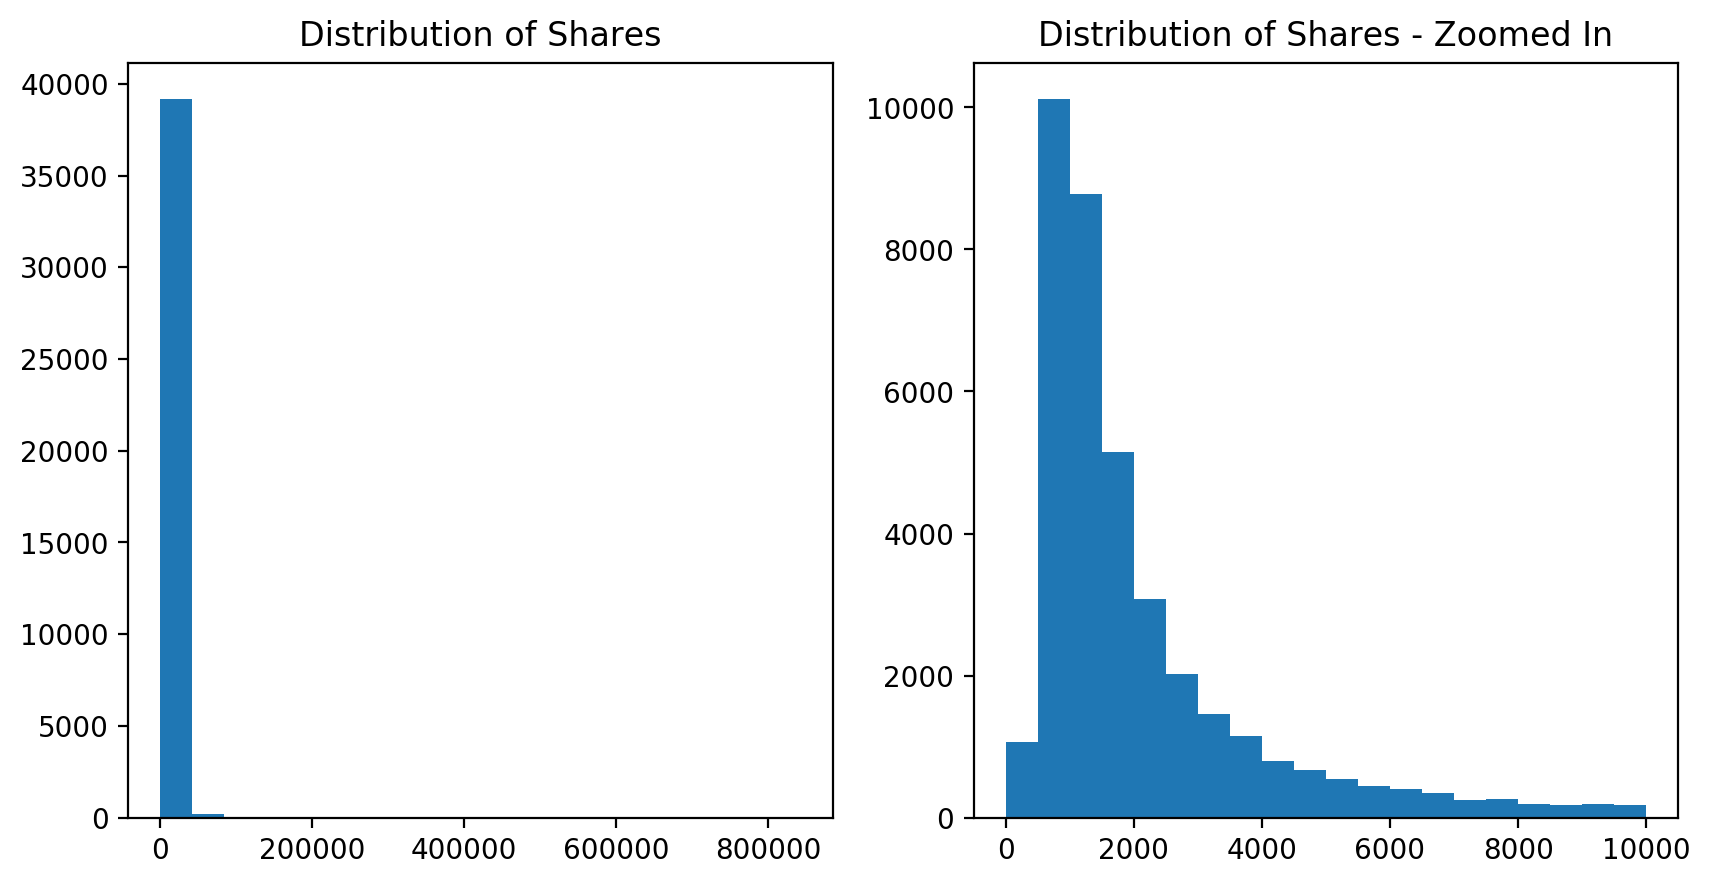

In [32]:
plt.figure(figsize=(10,5),dpi=200)

plt.subplot(121)
plt.hist(data['shares'],bins=20);
plt.title('Distribution of Shares')

plt.subplot(122)
plt.hist(data['shares'],bins=20,range=(0,10000))
plt.title('Distribution of Shares - Zoomed In');

Seems like there's alot of outlires. Viral articles get a whole lot more shares than the typical article

# Save Data

Saved the data as `OnlineNewsPopularity_Cleaned.csv`.

In [33]:
data.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,channel,date,title,keywords,weekday
url,,,,,,,,,,,,,,,,,,,,,
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.500000,-0.187500,0.000000,0.187500,593,Entertainment,2013-01-07,amazon's streaming video library now a little ...,"amazon, entertainment, media, video",Mon
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,711,Business,2013-01-07,ap's twitter to begin displaying sponsored tweets,"business, media, twitter",Mon
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,1500,Business,2013-01-07,apple's app store passes 40 billion downloads,"apple, apps, apps and software, business, mobile",Mon
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.000000,0.000000,0.500000,0.000000,1200,Entertainment,2013-01-07,this astronaut is rooting for notre dame tonight,"space, college football, entertainment, sports",Mon
http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,0.454545,0.136364,0.045455,0.136364,505,Tech,2013-01-07,new u-verse apps simplify sharing photos and v...,"apps, apps and software, at&t, ces, tech",Mon


In [34]:
data.to_csv('OnlineNewsPopularity_Clean.csv')